<h1>目录</h1>
    
1. [原理简介](#原理简介)<br>

2. [运行环境与数据集准备](#运行环境与数据集准备)<br>
   [1. 加载和准备数据集](#1.-加载和准备数据集)<br>

3. [创建模型](#创建模型)<br>
   [1. 生成器](#1.-生成器)<br>
   [2. 判别器](#2.-判别器)<br>
   [3. 生成器与判别器初始化](#3.-生成器与判别器初始化)<br>
     
4. [定义损失函数和优化器](#定义损失函数和优化器)<br>

5. [训练阶段](#训练阶段)<br>

6. [可视化](#可视化)<br>
   [1. 生成器与判别器损失函数曲线](#1.-生成器与判别器损失函数曲线)<br>
   [2. 训练过程展示](#2.-训练过程展示)<br>
   [3. 真（训练集中的）——假（网络生成的）图片对比](#3.-真（训练集中的）——假（网络生成的）图片对比)<br>


本任务将在 MNIST 数据集上完成一个 DCGAN 的项目。

下方动画展示了当训练了 50 个epoch （全部数据集迭代50次） 时*生成器*所生成的一系列图片。图片从随机噪声开始，随着时间的推移越来越像手写数字。

![dcgan](https://tianchi-public.oss-cn-hangzhou.aliyuncs.com/public/files/forum/161702077436083091617020767652.gif)


# 原理简介
DCGAN 是第⼀个全卷积 GAN，⿇雀虽⼩，五脏俱全，最适合新⼈实践。

![DCGAN结构图](https://tianchi-public.oss-cn-hangzhou.aliyuncs.com/public/files/forum/161702086376171991617020862448.jpeg)

DCGAN的⽣成器和判别器都采⽤了4层的⽹络结构。⽣成器⽹络结构如上图所⽰，输⼊为1×100的向量，然后经过⼀个全连接层学习，reshape为 4×4×1024的张量，再经过4个上采样的反卷积⽹络层，⽣成64×64的图，各层的配置如下：

![DCGAN网络配置-1](https://tianchi-public.oss-cn-hangzhou.aliyuncs.com/public/files/forum/161702089481195911617020892065.jpeg)

判别器输⼊64×64⼤⼩的图，经过4次卷积，分辨率降低为4×4的⼤⼩，每⼀个卷积层的配置如下：

![DCGAN网络配置-2](https://tianchi-public.oss-cn-hangzhou.aliyuncs.com/public/files/forum/161702093342370831617020931776.jpeg)





接下来我们进⾏实践，选择 PyTorch 框架，下⾯详解具体的⼯程代码，主要包括：

- 运行环境与数据集准备
- 创建模型
- 定义损失函数与优化器
- 训练模型
- 可视化


# 运行环境与数据集准备

1. 在加载该 NoteBook 文件时,会自动加载数据集至 `./download/DCGAN_PyTorch_MNIST_DATASET` 文件夹下。若没有自动加载数据集，则需要手动加载，手动加载方式如下：

**点击本页面左方 `天池` 按钮（需要在 CPU 环境下），点击 `DCGAN_PyTorch_MNIST_DATASET` 旁边的下载按钮，就会自动加载数据集了！**

![](https://tianchi-public.oss-cn-hangzhou.aliyuncs.com/public/files/forum/161715864081088081617158642543.jpeg)

运行下面代码，对数据集进行解压

In [ ]:
!unzip DCGAN_PyTorch_MNIST_DATASET.zip -d ./DCGAN_PyTorch_MNIST_DATASET

2. 同时该实战需要在 GPU 环境下才能运行，GPU 环境的切换方法如下：

**点击本页面右侧 `<` 键，会调出以下页面，然后点击切换即可切换至 GPU，切换时间会稍微长一点，请耐心等候！**

![](https://tianchi-public.oss-cn-hangzhou.aliyuncs.com/public/files/forum/161709441075480291617094410826.png)

In [2]:
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import utils, datasets, transforms
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

## 1. 加载和准备数据集

本项目使用 MNIST 数据集来训练生成器和判别器。生成器将生成类似于 MNIST 数据集的手写数字。
首先加载数据集，并设置初始参数。

> 在加载该 NoteBook 文件时,会自动加载数据集自 `DCGAN_PyTorch_MNIST_DATASET` 文件夹下

In [3]:
dataroot = "./data/"  # 数据集所在的路径，我们已经事先下载下来了
workers = 10  # 数据加载时的进程数
batch_size = 100  # 生成器输入的大小

image_size = 64  # 训练图像的大小
nc = 1  # 训练图像的通道数，彩色图像的话就是 3
nz = 100  # 输入是100 维的随机噪声 z，看作是 100 个 channel，每个特征图宽高是 1*1
ngf = 64  # 生成器中特征图的大小，
ndf = 64  # 判别器中特征图的大小
num_epochs = 10  # 训练的轮次
lr = 0.0002  # 学习率大小
beta1 = 0.5  # Adam 优化器的参数
ngpu = 1  # 可用 GPU  的个数，0 代表使用 CPU

# 训练集加载并进行归一化等操作
train_data = datasets.MNIST(
    root=dataroot,
    train=True,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5, ))
    ]),
    download=True  # 从互联网下载，如果已经下载的话，就直接使用
)

# 测试集加载并进行归一化等操作
test_data = datasets.MNIST(root=dataroot,
                           train=False,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, ), (0.5, ))
                           ]))

# 把 MNIST 的训练集和测试集都用来做训练
dataset = train_data + test_data
print(f'Total Size of Dataset: {len(dataset)}')

# 数据加载器，训练过程中不断产生数据
dataloader = DataLoader(dataset=dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=workers)

# 看是否存在可用的 GPU
device = torch.device('cuda:0' if (
    torch.cuda.is_available() and ngpu > 0) else 'cpu')

# 权重初始化函数
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Total Size of Dataset: 70000


> 以下的代码用做读取部分数据集进行展示，看看我们原始输入的数据是怎么样的。

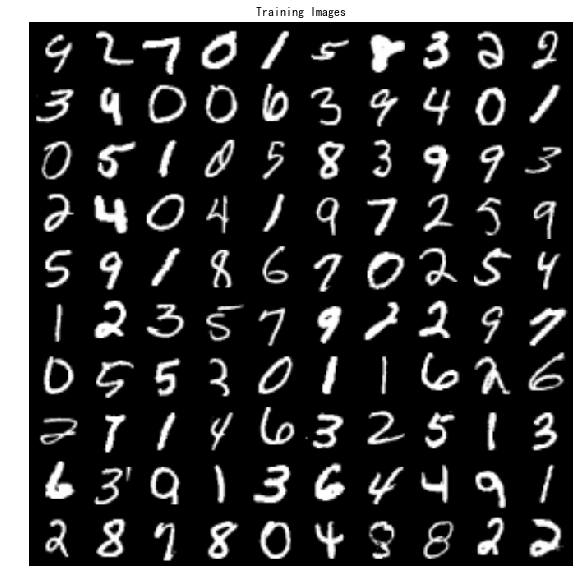

In [4]:
inputs = next(iter(dataloader))[0]
plt.figure(figsize=(10, 10))
plt.title("Training Images")
plt.axis('off')
inputs = utils.make_grid(inputs[:100] * 0.5 + 0.5, nrow=10) #把图片排列成网格形状 
plt.imshow(inputs.permute(1, 2, 0))

# 创建模型

## 1. 生成器

生成器使用 `torch.nn.ConvTranspose2d` （上采样）层来从种子（随机噪声）中产生图片。以一个使用该种子作为输入的 `Dense` 层开始，然后多次上采样直到达到所期望的 64x64x1 的图片尺寸。注意除了输出层使用 tanh 之外，其他每层均使用 `torch.nn.functional.relu` 作为激活函数。

下面定义一个生成器的类，读者可以依照生成器网络配置理解以下代码

In [5]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(in_channels=nz,
                               out_channels=ngf * 8,
                               kernel_size=4,
                               stride=1,
                               padding=0,
                               bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # 当前特征图大小  (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # 当前特征图大小 (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # 当前特征图大小 (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # 当前特征图大小 (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # 当前特征图大小 (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

## 2. 判别器

判别器是一个基于 CNN 的图片分类器。

In [6]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 输入 (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 当前特征图大小 (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 当前特征图大小 (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 当前特征图大小 (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # 当前特征图大小 (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            # 当前特征图大小 (1) x 1 x 1
            nn.Sigmoid())

    def forward(self, input):
        return self.main(input)

## 3. 生成器与判别器初始化

In [7]:
# 创建一个生成器对象
netG = Generator(ngpu).to(device)
# 多卡并行，如果有多卡的话
if device.type == 'cuda' and ngpu > 1:
    netG = nn.DataParallel(netG, list(range(ngpu)))

# 初始化权重  其中，mean=0, stdev=0.2.
netG.apply(weights_init)

# 创建一个判别器对象
netD = Discriminator(ngpu).to(device)
# 多卡并行，如果有多卡的话
if device.type == 'cuda' and ngpu > 1:
    netD = nn.DataParallel(netD, list(range(ngpu)))

# 初始化权重  其中，mean=0, stdev=0.2.
netD.apply(weights_init)
print(netG)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)
Discriminator(
  (ma

# 定义损失函数和优化器

为两个模型定义损失函数和优化器。

In [8]:
criterion = nn.BCELoss()  # 定义损失函数

# 创建一批潜在向量，我们将使用它们来可视化生成器的生成过程
fixed_noise = torch.randn(100, nz, 1, 1, device=device)

real_label = 1.  # “真”标签
fake_label = 0.  # “假”标签

# 为生成器和判别器定义优化器
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

# 训练阶段

DCGAN 的训练过程如下：

1、首先固定 Generator，训练 Discriminator
- 输入：真实数据 $x$，Generator 生成的数据 $G(x)$
- 输出：二分类概率

从噪声分布中随机采样噪声 $z$，经过 Generator 生成 $G(z)$。G(z)和 x 输入到 Discriminator 得到 $D(x)$ 和 $D(G(z))$，损失函数为 
$$\frac{1}{m} \sum_{i=1}^{m}\left[\log D\left(\boldsymbol{x}^{(i)}\right)+\log \left(1-D\left(G\left(\boldsymbol{z}^{(i)}\right)\right)\right)\right]$$ 

这里是最大化损失函数，因此使用梯度上升法更新参数。


2、固定 Discriminator，训练 Generator。
- 输入：随机噪声 $z$
- 输出：分类概率 $D(G(z))$，目的是使 $D(G(z))=1$

从噪声分布中重新随机采样噪声 $z$，经过 Generator 生成 $G(z)$。$G(z)$ 输入到 Discriminator 得到 $D(G(z))$，损失函数为

$$\frac{1}{m} \sum_{i=1}^{m} \log \left(1-D\left(G\left(z^{(i)}\right)\right)\right)$$

这里是最小化损失函数，使用梯度下降法更新参数。


In [8]:
# 定义一些变量，用来存储每轮的相关值
img_list = []
G_losses = []
D_losses = []
D_x_list = []
D_z_list = []
loss_tep = 10

print("Starting Training Loop...")
# 迭代
for epoch in range(num_epochs):
    beg_time = time.time()
    # 数据加载器读取数据
    for i, data in enumerate(dataloader):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # 用所有的真数据进行训练
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size, ),
                           real_label,
                           dtype=torch.float,
                           device=device)

        # 判别器推理
        output = netD(real_cpu).view(-1)

        # Calculate loss on all-real batch
        # 计算所有真标签的损失函数
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # 生成假数据并进行训练
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        
        # 用生成器生成假图像
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # 计算判别器在假数据上的损失
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        end_time = time.time()
        run_time = round(end_time - beg_time)
        print(f'Epoch: [{epoch+1:0>{len(str(num_epochs))}}/{num_epochs}]',
              f'Step: [{i+1:0>{len(str(len(dataloader)))}}/{len(dataloader)}]',
              f'Loss-D: {errD.item():.4f}',
              f'Loss-G: {errG.item():.4f}',
              f'D(x): {D_x:.4f}',
              f'D(G(z)): [{D_G_z1:.4f}/{D_G_z2:.4f}]',
              f'Time: {run_time}s',
              end='\r')

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Save D(X) and D(G(z)) for plotting later
        D_x_list.append(D_x)
        D_z_list.append(D_G_z2)

        # 保存最好的模型
        if errG < loss_tep:
            torch.save(netG.state_dict(), 'model.pt')
            temp = errG

    # Check how the generator is doing by saving G's output on fixed_noise
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_list.append(utils.make_grid(fake * 0.5 + 0.5, nrow=10))
    print()

Starting Training Loop...
Epoch: [01/10] Step: [700/700] Loss-D: 0.4373 Loss-G: 1.5101 D(x): 0.7454 D(G(z)): [0.1067/0.2597] Time: 77ss
Epoch: [02/10] Step: [700/700] Loss-D: 0.9204 Loss-G: 3.9537 D(x): 0.9857 D(G(z)): [0.5345/0.0318] Time: 81ss
Epoch: [03/10] Step: [700/700] Loss-D: 0.6607 Loss-G: 3.1009 D(x): 0.7830 D(G(z)): [0.2888/0.0680] Time: 80ss
Epoch: [04/10] Step: [700/700] Loss-D: 0.7066 Loss-G: 0.7525 D(x): 0.5510 D(G(z)): [0.0132/0.5375] Time: 81ss
Epoch: [05/10] Step: [700/700] Loss-D: 0.7059 Loss-G: 1.5657 D(x): 0.6637 D(G(z)): [0.1957/0.2554] Time: 80ss
Epoch: [06/10] Step: [700/700] Loss-D: 0.0573 Loss-G: 4.4857 D(x): 0.9823 D(G(z)): [0.0366/0.0171] Time: 81ss
Epoch: [07/10] Step: [700/700] Loss-D: 0.2345 Loss-G: 11.2492 D(x): 0.9982 D(G(z)): [0.1892/0.0000] Time: 80s
Epoch: [08/10] Step: [700/700] Loss-D: 0.0299 Loss-G: 4.7122 D(x): 0.9905 D(G(z)): [0.0198/0.0145] Time: 81ss
Epoch: [09/10] Step: [700/700] Loss-D: 0.7333 Loss-G: 2.5403 D(x): 0.5582 D(G(z)): [0.0182/0.1

模型训练完毕后，会保存成一个 `model.pt` 文件

# 可视化
## 1. 生成器与判别器损失函数曲线

NameError: name 'G_losses' is not defined

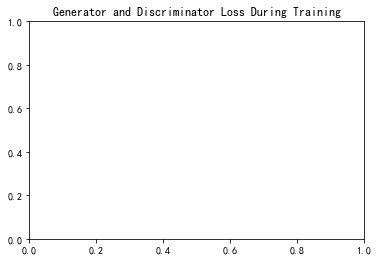

In [10]:
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses[::100], label="G")
plt.plot(D_losses[::100], label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.axhline(y=0, label="0", c="g")  # asymptote
plt.legend()

## 2. 训练过程展示

NameError: name 'img_list' is not defined

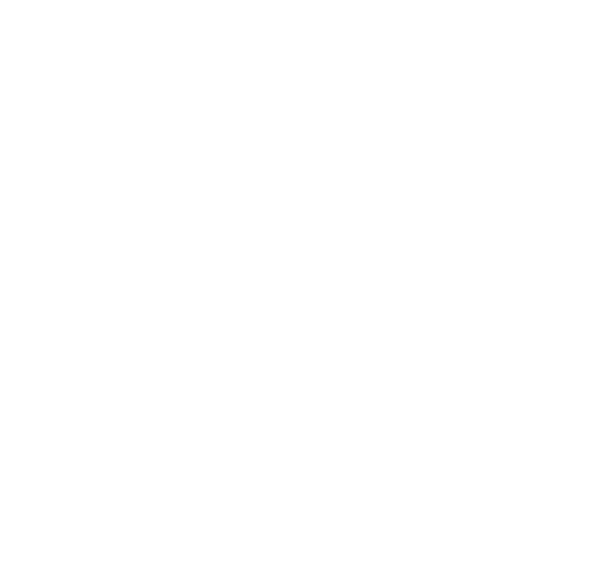

In [11]:
fig = plt.figure(figsize=(10, 10))
plt.axis("off")
ims = [[plt.imshow(item.permute(1, 2, 0), animated=True)] for item in img_list]
ani = animation.ArtistAnimation(fig,
                                ims,
                                interval=1000,
                                repeat_delay=1000,
                                blit=True)
HTML(ani.to_jshtml())

## 3. 真（训练集中的）——假（网络生成的）图片对比

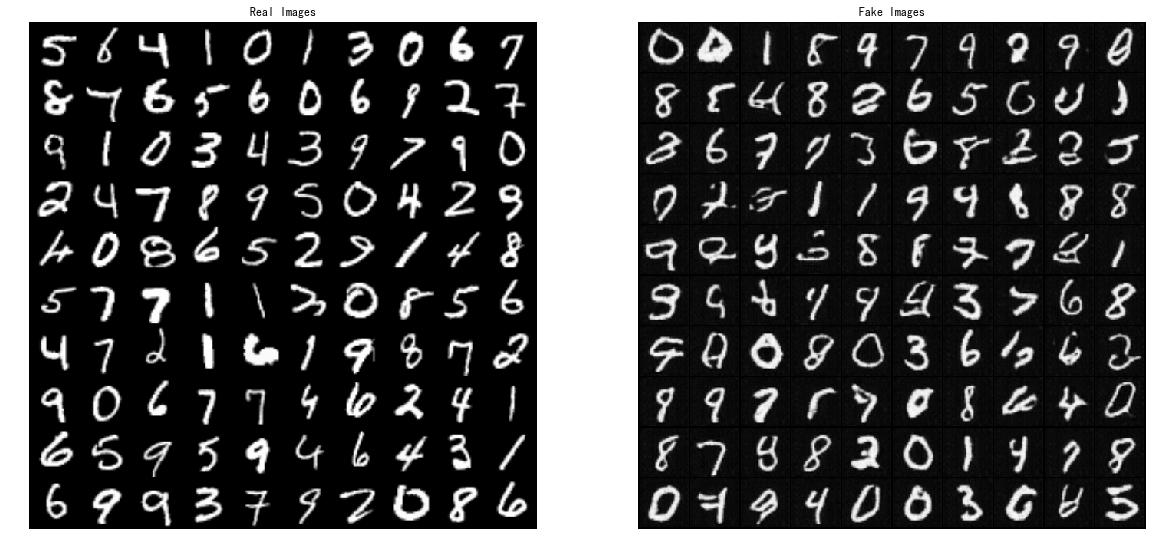

In [10]:
# Size of the Figure
plt.figure(figsize=(20, 10))

# Plot the real images
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
real = next(iter(dataloader))
plt.imshow(
    utils.make_grid(real[0][:100] * 0.5 + 0.5, nrow=10).permute(1, 2, 0))

# Load the Best Generative Model
netG = Generator(0)
netG.load_state_dict(torch.load('model.pt', map_location=torch.device('cpu')))
netG.eval()

# Generate the Fake Images
with torch.no_grad():
    fake = netG(fixed_noise.cpu())

# Plot the fake images
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
fake = utils.make_grid(fake * 0.5 + 0.5, nrow=10)
plt.imshow(fake.permute(1, 2, 0))

# Save the comparation result
plt.savefig('result.jpg', bbox_inches='tight')